# Tet-below-Vinca microplastic modelling - spatial rainfall

Create an input of rainfall that is spatially distributed for the area below the Vinca dam.

### Check data downloaded from Meteo France

I have two files, a html file that describes my stations and a text file that has the data. Lets sort these out into something useful. Copy paste html to Microsoft Excel is the easiest, then deal with the idiotic format.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns
import rasterio as rio
from rasterio.plot import show
import pyvista as pv
import statsmodels.api as sm
from osgeo import gdal
import datetime
from pyproj import Proj, Transformer

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import caesarpy as cp

from pyvista import set_plot_theme
set_plot_theme('document')

In [2]:
rain_loc = pd.read_excel('./tet/rainfall-data-description.xlsx')

In [3]:
rain_loc.columns = [x.replace("\n", " ") for x in rain_loc.columns.to_list()]
rain_loc = rain_loc.rename(columns={'Unnamed: 3':'epsg:4326', 'Unnamed: 5':'epsg:27572'}, errors='raise')

In [4]:
rain_loc_clean = rain_loc[rain_loc['Coordonnées'] == 'Latitude'].copy()
rain_loc_lon = rain_loc[rain_loc['Coordonnées'] == 'Longitude'].copy()

rain_loc_clean['epsg:4326 lon'] = rain_loc_lon['epsg:4326'].values
rain_loc_clean['epsg:27572 X'] = rain_loc_lon['epsg:27572'].values
rain_loc_clean = rain_loc_clean.rename(columns={'epsg:4326':'epsg:4326 lat', 'epsg:27572':'epsg:27572 Y'}, errors='raise')

In [5]:
transformer = Transformer.from_crs("epsg:27572", "epsg:2154")
Xrain, Yrain = transformer.transform(rain_loc_clean['epsg:27572 X'].values, rain_loc_clean['epsg:27572 Y'].values)

### Change coordinate system
The dataframe of station locations should be usable now, just need to transform the Lambert 2 entendu coordinates into something more useful.

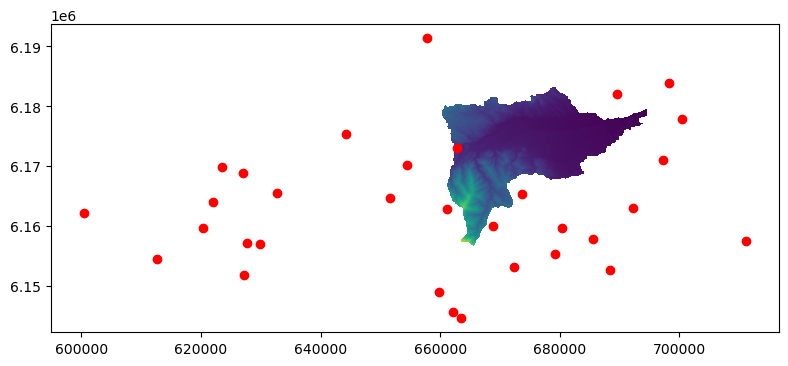

In [6]:
path_to_tif = './tet/'

resampled_raster = '{}dem_clipped.tif'.format(path_to_tif)

dem = rio.open(resampled_raster)  # read in tif file
topo = dem.read(1).astype(float)  # assume that elevation is in the first band
topo[topo <= 0] = np.nan  # replace -9999 with nan

fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(10, 4), sharey=True)
rio.plot.show(dem, ax=ax1)
plt.scatter(Xrain, Yrain, label=rain_loc_clean['Numéro'], color='red')
plt.show()

### Extract rainfall time series
Extract each rainfall time series from the downloaded file where the first column is the station ID

In [7]:
station_ids = np.floor(rain_loc_clean['Numéro'].values).astype(int)

In [8]:
station_ids

array([66002001, 66003001, 66004401, 66013001, 66024001, 66026001,
       66029003, 66037001, 66049001, 66062001, 66074002, 66082004,
       66082400, 66117001, 66119002, 66124402, 66136001, 66137003,
       66147402, 66148001, 66157001, 66183001, 66187006, 66188401,
       66192003, 66194002, 66204002, 66206001, 66206004, 66212001,
       66230001, 66233001])

In [9]:
rain_df = pd.read_csv('/work/armitagj/code/caesarPy/dem-preprocessing/tet/rainfall-data.txt', delimiter=';', decimal=',')

In [10]:
rainfall = np.zeros((len(station_ids), 909))
for i, station_id in enumerate(station_ids):
    rainfall[i, :] = rain_df.loc[rain_df['POSTE'] == station_id, 'RR'].values

In [11]:
all_rain_df = pd.DataFrame(data=rainfall.T, columns=map(str, station_ids))

In [12]:
all_rain_df['datetime'] = pd.date_range(start='10/1/2015 12:00:00', periods=909, freq='D')

In [13]:
all_rain_df

,66002001,66003001,66004401,66013001,66024001,66026001,66029003,66037001,66049001,66062001,...,66188401,66192003,66194002,66204002,66206001,66206004,66212001,66230001,66233001,datetime
0,0.0,5.0,NaN,2.5,0.0,0.5,2.4,0.0,1.0,2.7,...,NaN,8.0,2.8,2.4,2.0,4.3,0.2,2.3,0.4,2015-10-01 12:00:00
1,2.5,19.0,NaN,3.2,6.2,3.0,16.0,2.0,19.3,4.6,...,NaN,14.0,0.8,5.8,1.0,19.7,4.9,5.5,12.6,2015-10-02 12:00:00
2,11.0,12.0,NaN,3.7,16.0,20.0,4.6,10.3,2.5,1.2,...,NaN,0.0,16.6,0.7,18.0,7.3,5.4,1.0,10.7,2015-10-03 12:00:00
3,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-10-04 12:00:00
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,2015-10-05 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,4.0,6.0,5.0,5.6,4.0,0.7,6.5,8.2,8.0,4.7,...,NaN,1.0,2.6,5.0,2.5,3.0,4.4,5.0,4.8,2018-03-23 12:00:00
905,18.0,9.3,NaN,12.3,25.4,22.5,33.0,17.3,16.8,3.6,...,NaN,2.0,8.8,13.1,11.0,10.3,17.6,11.0,14.8,2018-03-24 12:00:00
906,0.0,2.6,NaN,4.2,0.0,0.0,0.6,0.0,0.0,1.4,...,NaN,2.4,1.2,1.8,1.6,5.9,0.0,2.0,1.0,2018-03-25 12:00:00
907,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.6,...,NaN,0.0,0.0,0.0,0.0,0.2,0.2,0.9,0.0,2018-03-26 12:00:00


In [14]:
all_rain_df = all_rain_df.set_index('datetime', drop=False)

<Figure size 2500x5000 with 0 Axes>

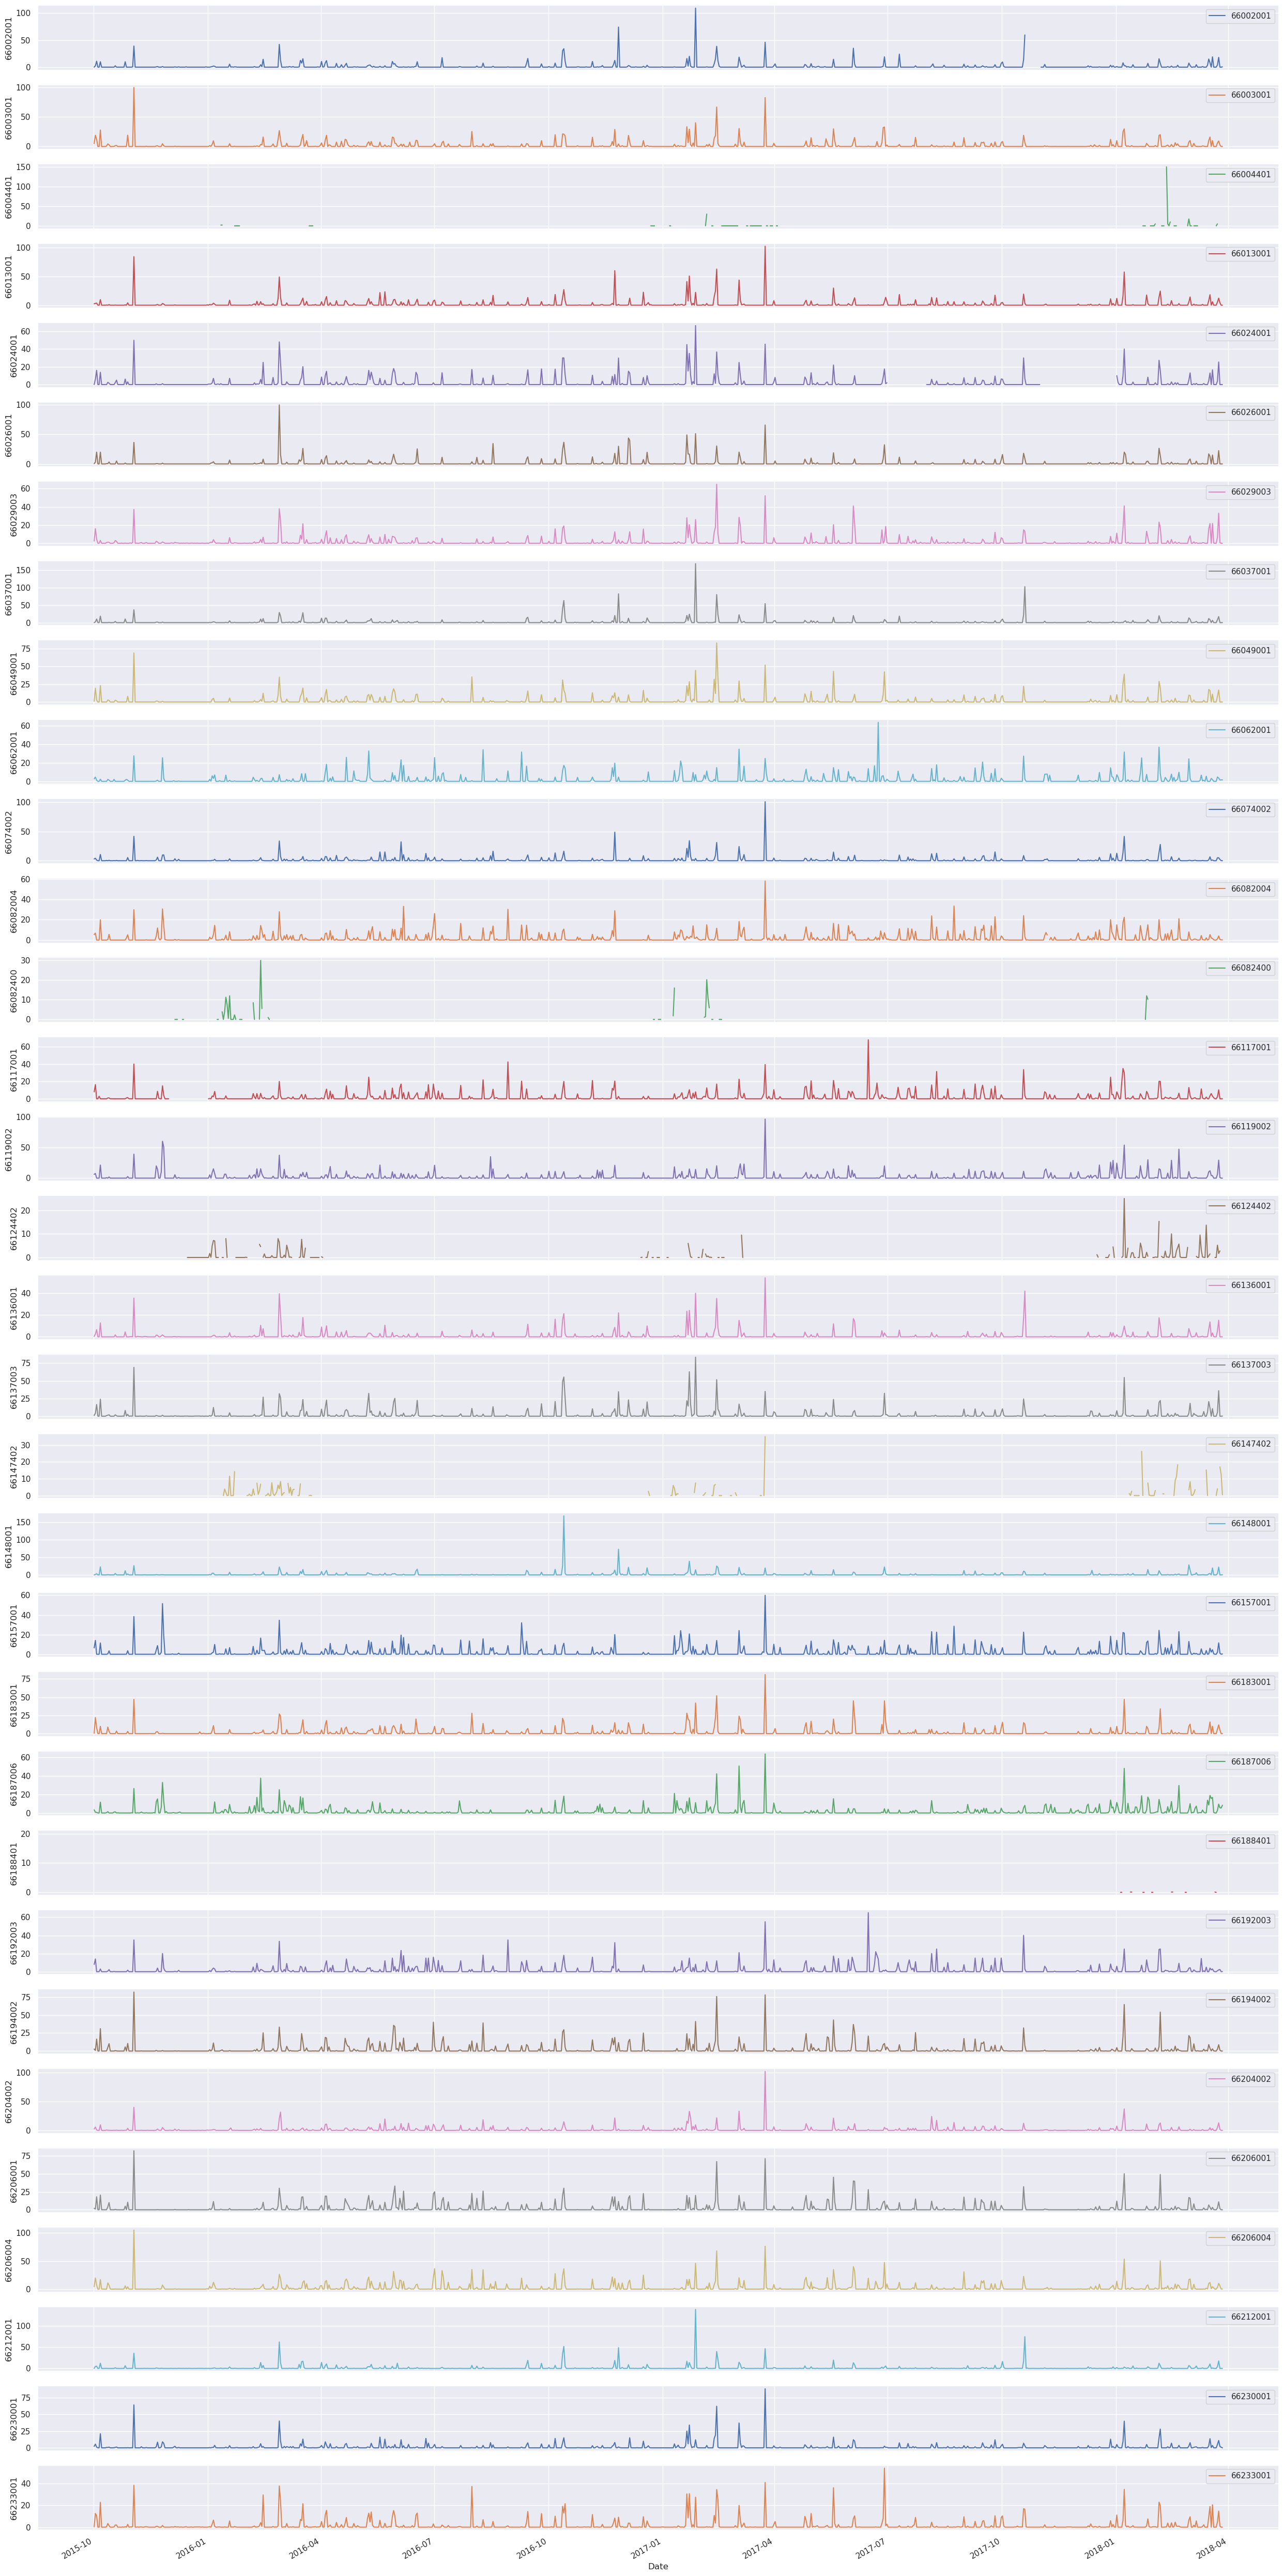

In [15]:
sns.set(rc={'figure.figsize':(25, 50)})
plt.figure()
cols_plot = map(str, station_ids)
cols_label = station_ids
axes = all_rain_df[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_label[i])
    i += 1
plt.xlabel('Date')
plt.tight_layout()
plt.show()

Drop columns with too little data to be useful.

In [16]:
all_rain_df.drop(columns=['66004401', '66082400', '66124402', '66148001', '66188401'], inplace=True)
all_rain_df

,66002001,66003001,66013001,66024001,66026001,66029003,66037001,66049001,66062001,66074002,...,66187006,66192003,66194002,66204002,66206001,66206004,66212001,66230001,66233001,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2015-10-01 12:00:00,0.0,5.0,2.5,0.0,0.5,2.4,0.0,1.0,2.7,3.0,...,3.4,8.0,2.8,2.4,2.0,4.3,0.2,2.3,0.4,2015-10-01 12:00:00
2015-10-02 12:00:00,2.5,19.0,3.2,6.2,3.0,16.0,2.0,19.3,4.6,4.2,...,0.8,14.0,0.8,5.8,1.0,19.7,4.9,5.5,12.6,2015-10-02 12:00:00
2015-10-03 12:00:00,11.0,12.0,3.7,16.0,20.0,4.6,10.3,2.5,1.2,1.0,...,0.6,0.0,16.6,0.7,18.0,7.3,5.4,1.0,10.7,2015-10-03 12:00:00
2015-10-04 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-10-04 12:00:00
2015-10-05 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,2015-10-05 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-23 12:00:00,4.0,6.0,5.6,4.0,0.7,6.5,8.2,8.0,4.7,5.0,...,2.8,1.0,2.6,5.0,2.5,3.0,4.4,5.0,4.8,2018-03-23 12:00:00
2018-03-24 12:00:00,18.0,9.3,12.3,25.4,22.5,33.0,17.3,16.8,3.6,5.0,...,9.6,2.0,8.8,13.1,11.0,10.3,17.6,11.0,14.8,2018-03-24 12:00:00
2018-03-25 12:00:00,0.0,2.6,4.2,0.0,0.0,0.6,0.0,0.0,1.4,2.0,...,5.6,2.4,1.2,1.8,1.6,5.9,0.0,2.0,1.0,2018-03-25 12:00:00


Now that the bad data is dropped, recreate the locations database

In [17]:
len(rain_loc_clean)

32

In [18]:
baddata = [66004401, 66082400, 66124402, 66148001, 66188401]
for bad in baddata:
    rain_loc_clean.drop(rain_loc_clean[rain_loc_clean['Numéro'] == bad].index, inplace=True)

In [19]:
len(rain_loc_clean)

27

In [20]:
rain_loc_clean['ID'] = np.arange(len(rain_loc_clean))

In [21]:
transformer = Transformer.from_crs("epsg:27572", "epsg:2154")
Xrain, Yrain = transformer.transform(rain_loc_clean['epsg:27572 X'].values, rain_loc_clean['epsg:27572 Y'].values)

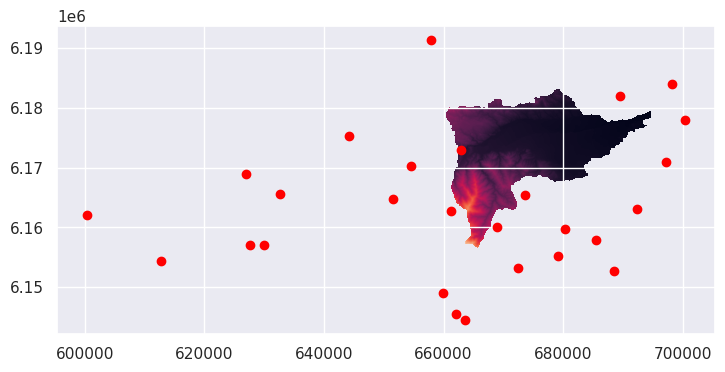

In [22]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(10, 4), sharey=True)
rio.plot.show(dem, ax=ax1)
plt.scatter(Xrain, Yrain, label=rain_loc_clean['Numéro'], color='red')
plt.show()

### Create DEM for rainfall data 

Need to relate the station id to a number, and create a DEM that maps that number to an area.

In [23]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [24]:
points = np.array([Xrain, Yrain]).T

In [25]:
np.shape(points)

(27, 2)

In [26]:
vor = Voronoi(points)

<Figure size 1000x400 with 0 Axes>

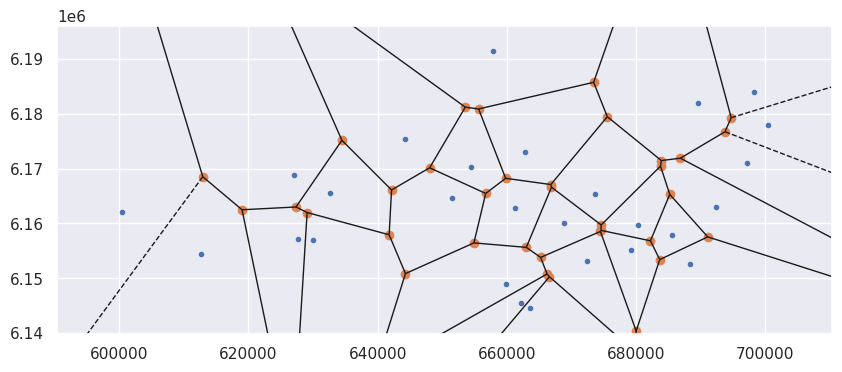

In [27]:
sns.set(rc={'figure.figsize':(10, 4)})
plt.figure()
fig = voronoi_plot_2d(vor)
plt.show()

In [28]:
def asc2numpy(ascfile):
    """
    Function to read in an ascii file (.asc) and return a Numpy array
    :param ascfile: input ascii file name
    :return ncols: number of columns
    :return nrows: number of rows
    :return geotransform: the geo-transfrom info
    :return data: a numpy array of the ascii data
    """

    try:
        gdal_data = gdal.Open(ascfile)  # use GDAL to open the ascii fle
        ncols = gdal_data.RasterXSize  # get the number of columns
        nrows = gdal_data.RasterYSize  # get the number of rows
        geotransform = gdal_data.GetGeoTransform()  # get the geo-transform info
        data_array = gdal_data.ReadAsArray().astype(float)  # convert the data into a numpy array
        data_array[data_array <= -9999] = np.nan  # replace -9999 with nan

        return ncols, nrows, geotransform, data_array

    except:
        print('cannot open {}'.format(ascfile))

In [29]:
dem_asc = '{}dem_200m_preproc.asc'.format(path_to_tif)
nx, ny, geotransform, dem = asc2numpy(dem_asc)

In [30]:
ul = (geotransform[0], geotransform[3])
lr = (geotransform[0] + nx * geotransform[1], geotransform[3] + ny * geotransform[5])
print(f'ul = {ul}; lr = {lr}')

ul = (660012.5, 6183387.5); lr = (694412.5, 6156387.5)


In [31]:
from scipy.interpolate import griddata

There should be n+1 nodes and n cells...

In [32]:
np.shape(dem)

(135, 172)

In [33]:
dx = abs(geotransform[1])
dy = abs(geotransform[5])
x = np.linspace(ul[0] + dx/2, lr[0] - dx/2, nx)
y = np.linspace(lr[1] + dy/2, ul[1] - dy/2, ny)
X, Y = np.meshgrid(x, y, indexing='xy')

In [34]:
labels = griddata(points, np.array(rain_loc_clean['ID'].values), (X, Y), method='nearest')

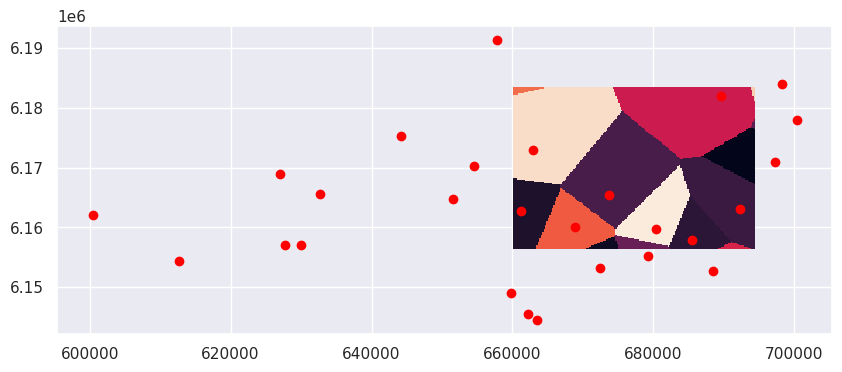

In [35]:
plt.figure()
plt.pcolormesh(X, Y, labels)
plt.scatter(Xrain, Yrain, label=rain_loc_clean['Numéro'], color='red')
plt.show()

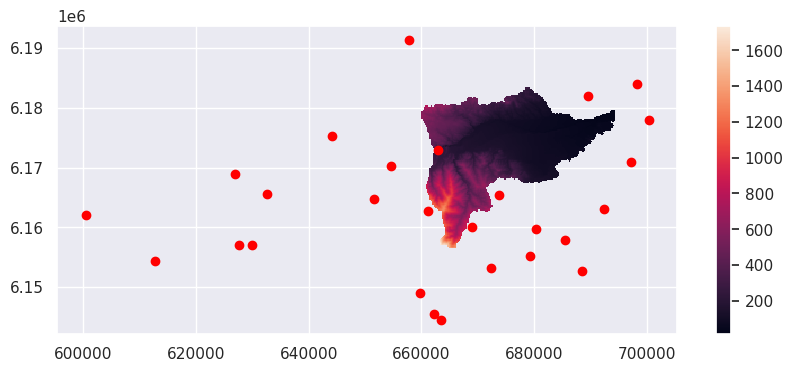

In [36]:
plt.figure()
plt.pcolormesh(X, Y, np.flipud(dem))
plt.colorbar()
plt.scatter(Xrain, Yrain, label=rain_loc_clean['Numéro'], color='red')
plt.show()

In [37]:
labels = labels.astype(float)
labels[np.isnan(np.flipud(dem))] = np.nan

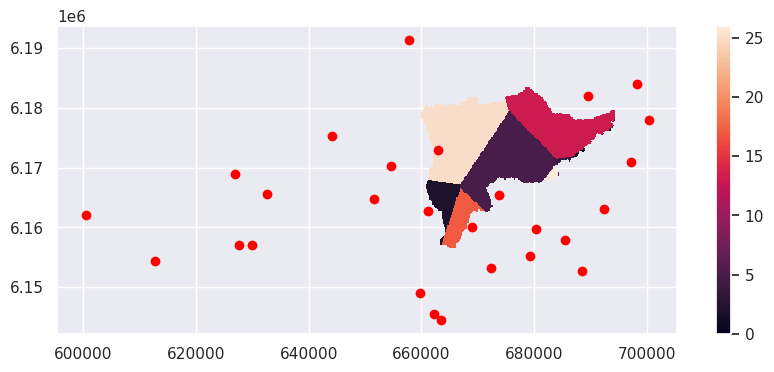

In [38]:
plt.figure()
plt.pcolormesh(X, Y, labels)
plt.colorbar()
plt.scatter(Xrain, Yrain, label=rain_loc_clean['Numéro'], color='red')
plt.show()

In [39]:
used_stations_ = np.unique(labels)
used_stations = used_stations_[np.isnan(used_stations_) != True].astype(int)
used_stations

array([ 0,  2,  4,  5,  6, 13, 17, 25, 26])

In [40]:
relabels = griddata(points[used_stations, :], np.arange(1, len(used_stations)+1), (X, Y), method='nearest')

In [41]:
relabels = relabels.astype(float)
relabels[np.isnan(np.flipud(dem))] = np.nan

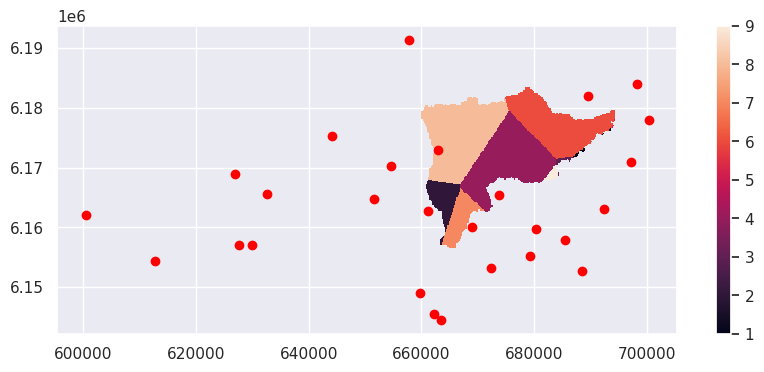

In [42]:
plt.figure()
plt.pcolormesh(X, Y, relabels)
plt.colorbar()
plt.scatter(Xrain, Yrain, label=rain_loc_clean['Numéro'], color='red')
plt.show()

In [43]:
np.unique(relabels)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan])

In [44]:
used_ids = []
for station in used_stations:
    used_ids.append(rain_loc_clean.loc[rain_loc_clean['ID'] == station, 'Numéro'].iloc[0])
print(used_ids)

[66002001.0, 66013001.0, 66026001.0, 66029003.0, 66037001.0, 66136001.0, 66183001.0, 66230001.0, 66233001.0]


In [45]:
used_rainfall = np.zeros((909, len(used_ids)))
for i, station_id in enumerate(used_ids):
    used_rainfall[:, i] = rain_df.loc[rain_df['POSTE'] == station_id, 'RR'].values / 24  # per day to per hr

In [46]:
np.shape(used_rainfall)

(909, 9)

### Save data to file

In [47]:
def numpy2asc(array, tiffile, ascfile):
    """
    Function to convert a geotiff (.tif) file into an ascii file (.asc)
    :param tiffile: input geotiff file name
    :param ascfile: output ascii file name (CAESAR expects .asc)
    :return: None
    """
    rio_array = rio.open(tiffile)  # read in tif file
    
    f = open(ascfile, 'w')
    f.write('ncols         {}\n'.format(np.shape(array)[1]))
    f.write('nrows         {}\n'.format(np.shape(array)[0]))
    f.write('xllcorner     {}\n'.format((rio_array.transform * (0, rio_array.height))[0]))
    f.write('yllcorner     {}\n'.format((rio_array.transform * (0, rio_array.height))[1]))
    f.write('cellsize      {}\n'.format(rio_array.transform[0]))
    f.write('NODATA_value  -9999\n')

    pix = '{0} '
    for i in range(np.shape(array)[0]):
        for j in range(np.shape(array)[1]):
            if np.isnan(array[i, j]) == True:
                f.write(pix.format(int(-9999)))  # need to replace nan with -9999
            elif array[i, j] <= 0:
                f.write(pix.format(int(-9999)))  # need to replace 0 with -9999
            else:
                f.write(pix.format(array[i, j].astype(int)))
        f.write("\n")
    f.close()

In [48]:
resampled_raster = '{}dem_200m_mean.tif'.format(path_to_tif)
rain_asc = '{}spatial_rain_200m.asc'.format(path_to_tif)
numpy2asc(np.flipud(relabels), resampled_raster, rain_asc)

**For some reason the asc files are flipped up-down. No clue. But flip it for now** 

In [49]:
used_rainfall

array([[0.        , 0.10416667, 0.02083333, ..., 0.02083333, 0.09583333,
        0.01666667],
       [0.10416667, 0.13333333, 0.125     , ..., 0.91666667, 0.22916667,
        0.525     ],
       [0.45833333, 0.15416667, 0.83333333, ..., 0.33333333, 0.04166667,
        0.44583333],
       ...,
       [0.        , 0.175     , 0.        , ..., 0.20833333, 0.08333333,
        0.04166667],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0375    ,
        0.        ],
       [0.02083333, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [50]:
for i in range(np.shape(used_rainfall)[0]):
    for j in range(np.shape(used_rainfall)[1]):
        if np.isnan(used_rainfall[i][j]) == True:
            used_rainfall[i][j] = 0
            day = all_rain_df['datetime'].iloc[i]
            station = rain_loc_clean['Numéro'].iloc[used_stations[j]]
            print(f'ID: {station}, day: {day}, Nan replaced with zero')

ID: 66002001.0, day: 2017-10-20 12:00:00, Nan replaced with zero
ID: 66002001.0, day: 2017-10-21 12:00:00, Nan replaced with zero
ID: 66002001.0, day: 2017-10-22 12:00:00, Nan replaced with zero
ID: 66002001.0, day: 2017-10-23 12:00:00, Nan replaced with zero
ID: 66002001.0, day: 2017-10-24 12:00:00, Nan replaced with zero
ID: 66002001.0, day: 2017-10-25 12:00:00, Nan replaced with zero
ID: 66002001.0, day: 2017-10-26 12:00:00, Nan replaced with zero
ID: 66002001.0, day: 2017-10-27 12:00:00, Nan replaced with zero
ID: 66002001.0, day: 2017-10-28 12:00:00, Nan replaced with zero
ID: 66002001.0, day: 2017-10-29 12:00:00, Nan replaced with zero
ID: 66002001.0, day: 2017-10-30 12:00:00, Nan replaced with zero
ID: 66002001.0, day: 2017-10-31 12:00:00, Nan replaced with zero


In [51]:
np.savetxt(f'{path_to_tif}spatial_rain.txt', used_rainfall, fmt='%.4f', delimiter=' ', newline='\n')

In [52]:
print(f'The following stations were used: {np.array(used_ids).astype(int)}')

The following stations were used: [66002001 66013001 66026001 66029003 66037001 66136001 66183001 66230001
 66233001]


In [53]:
rain_loc_clean.set_index('Numéro', drop=True, inplace=True)

In [54]:
rain_loc_clean = rain_loc_clean.reindex(sorted(rain_loc_clean.columns), axis=1)

In [55]:
used_stations_df = rain_loc_clean.loc[used_ids, :].copy()

## Plot the mean rainfall

In [56]:
station_area = np.zeros(len(used_stations))
weighted_rain = np.zeros((909, len(used_stations)))
flat_labels = labels.flatten()
for i, sid in enumerate(used_stations):
    station_area[i] = len(flat_labels[flat_labels == sid]) / len(flat_labels[np.isnan(flat_labels) != True])
    weighted_rain[:, i] = used_rainfall[:, i] * station_area[i]

In [57]:
daily_mean_precip = np.zeros(909)
j = 0
for i in range(909):
    daily_mean_precip[j] = sum(weighted_rain[i, :])
    j = j + 1

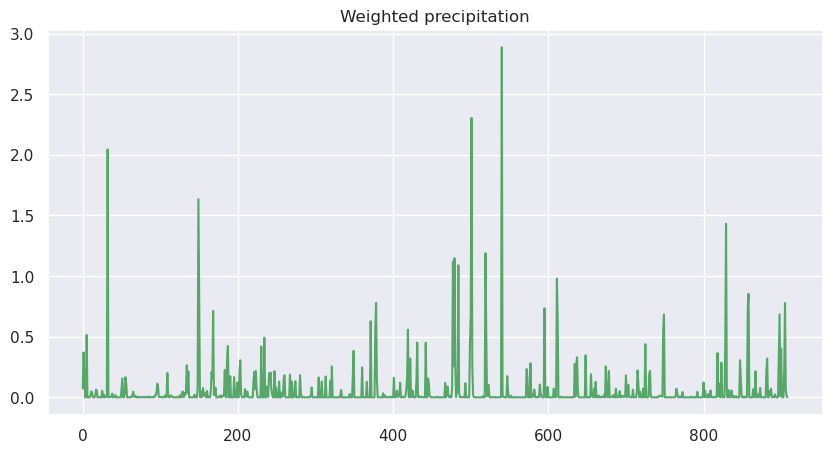

In [58]:
sns.set(rc={'figure.figsize':(10, 5)})
plt.figure()
plt.plot(daily_mean_precip, color="g")
plt.title(f'Weighted precipitation')
plt.show()

In [59]:
with open('./tet/mean_rainfall_below_vinca.npy', 'wb') as f:
    np.save(f, daily_mean_precip)

## Make 80, 60 and 40% rainfall output

In [60]:
np.savetxt(f'{path_to_tif}spatial_rain_80pc.txt', 0.8 * used_rainfall, fmt='%.4f', delimiter=' ', newline='\n')

In [61]:
np.savetxt(f'{path_to_tif}spatial_rain_60pc.txt', 0.6 * used_rainfall, fmt='%.4f', delimiter=' ', newline='\n')

In [62]:
np.savetxt(f'{path_to_tif}spatial_rain_40pc.txt', 0.4 * used_rainfall, fmt='%.4f', delimiter=' ', newline='\n')

In [63]:
np.savetxt(f'{path_to_tif}spatial_rain_20pc.txt', 0.2 * used_rainfall, fmt='%.4f', delimiter=' ', newline='\n')